## RNN 적용 실습
### IMDB 데이터셋(영화 감상평)을 이용한 긍정/부정 평가 분류 모델

In [1]:
from tensorflow.keras.datasets import imdb

In [2]:
# 자주 등장하는 500개 단어만 사용
(train_input, train_target),(test_input, test_target) = imdb.load_data(num_words=500)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
train_input.shape, test_input.shape

((25000,), (25000,))

### 데이터 수집 및 훈련/테스트 데이터 분리

In [4]:
train_target.shape, test_target.shape

((25000,), (25000,))

In [6]:
len(train_input[0]) # 훈련용 첫 번째 감상평 문장 길이

218

In [7]:
len(train_input[1]) # 훈련용 두 번째 감상평 문장 길이

189

In [8]:
train_target[:30] # 1 : 긍정, 0 : 부정

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0])

### 훈련 / 검증 데이터 분리

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state = 42
)

###  문장의 길이를 일치 시키는 전처리 작업

In [11]:
# padding 문장 앞쪽에 패딩을 넣는다.
import numpy as np

In [12]:
lengths = np.array([len(x) for x in train_input])
# 평균 문자 길이, 문장 길이 중앙값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


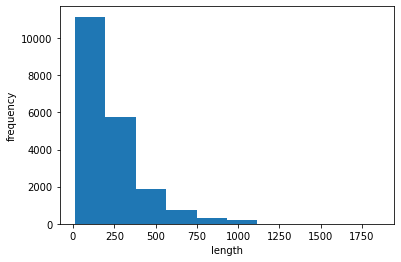

In [13]:
import matplotlib.pyplot as plt

plt. hist(lengths)
plt. xlabel('length')
plt.ylabel('frequency')

plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
train_seq = pad_sequences(train_input, maxlen= 100) # 문장의 길이를 100으로 맞춘다.

In [16]:
print(train_seq.shape)

(20000, 100)


In [17]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [18]:
print(train_seq[5]) # 앞쪽에 패딩이 들어간 경우

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [19]:
val_seq = pad_sequences(val_input, maxlen = 100)

## 순환 신경망 생성 및 훈련

In [20]:
from tensorflow import keras

In [21]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100,500))) # 100 - 문장 단어 수, 500 - 단어 개수
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 4072      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 훈련 데이터에 대한 원-핫 인코딩

In [23]:
# 단어 수 만큼 원핫 인코딩
train_oh = keras.utils.to_categorical(train_seq)
val_oh = keras.utils.to_categorical(val_seq)

In [24]:
train_oh.shape

(20000, 100, 500)

In [27]:
# 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model.compile(optimizer= rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights = True)
history = model.fit(train_oh, train_target, epochs=10, batch_size=64,
                    validation_data = (val_oh, val_target),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/10
313/313 [==============================] - 15s 43ms/step - loss: 0.6994 - accuracy: 0.5084 - val_loss: 0.6914 - val_accuracy: 0.5324
Epoch 2/10
313/313 [==============================] - 12s 37ms/step - loss: 0.6762 - accuracy: 0.5740 - val_loss: 0.6586 - val_accuracy: 0.6192
Epoch 3/10
313/313 [==============================] - 12s 38ms/step - loss: 0.6472 - accuracy: 0.6385 - val_loss: 0.6363 - val_accuracy: 0.6596
Epoch 4/10
313/313 [==============================] - 12s 37ms/step - loss: 0.6235 - accuracy: 0.6737 - val_loss: 0.6157 - val_accuracy: 0.6810
Epoch 5/10
313/313 [==============================] - 12s 38ms/step - loss: 0.6024 - accuracy: 0.6975 - val_loss: 0.5975 - val_accuracy: 0.7000
Epoch 6/10
313/313 [==============================] - 12s 37ms/step - loss: 0.5827 - accuracy: 0.7189 - val_loss: 0.5823 - val_accuracy: 0.7110
Epoch 7/10
313/313 [==============================] - 12s 38ms/step - loss: 0.5650 - accuracy: 0.7344 - val_loss: 0.5682 - val_accuracy:

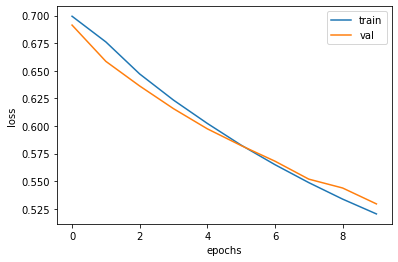

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

### 단어 임베딩을 이용한 RNN 모델

In [42]:
model = keras.Sequential()
# Embedding vector layer(임베딩 벡터층) - 임베팅 벡터 : 연광성 있는 단어를 실수 형태로 모아놓은 vector
# Embedding vector를 사용하면 메모리를 적게 사용
model.add(keras.layers.Embedding(500, 16, input_length= 100))
model.add(keras.layers.SimpleRNN(8)) 
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model.compile(optimizer= rmsprop, loss = 'binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights = True)
history = model.fit(train_seq, train_target, epochs=10, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6876 - accuracy: 0.5365 - val_loss: 0.6655 - val_accuracy: 0.6142
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6436 - accuracy: 0.6543 - val_loss: 0.6310 - val_accuracy: 0.6734
Epoch 3/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6122 - accuracy: 0.7057 - val_loss: 0.6092 - val_accuracy: 0.7016
Epoch 4/10
313/313 [==============================] - 6s 20ms/step - loss: 0.5883 - accuracy: 0.7308 - val_loss: 0.5870 - val_accuracy: 0.7332
Epoch 5/10
313/313 [==============================] - 6s 20ms/step - loss: 0.5690 - accuracy: 0.7474 - val_loss: 0.5740 - val_accuracy: 0.7354
Epoch 6/10
313/313 [==============================] - 6s 20ms/step - loss: 0.5521 - accuracy: 0.7592 - val_loss: 0.5655 - val_accuracy: 0.7350
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 0.5367 - accuracy: 0.7699 - val_loss: 0.5554 - val_accuracy: 0.7486

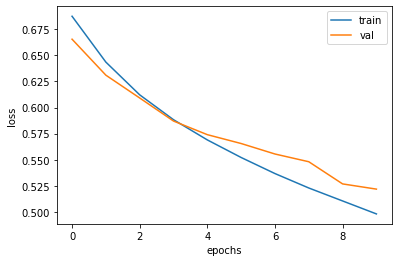

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()